In [29]:
import torch
import dlc_practical_prologue as prologue

from torch.autograd import Variable
from torch import nn
from torch.nn import functional as F

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display,clear_output
from itertools import product

## Load data and prepare it for training

In [30]:
# Download data
train_input, train_target, train_classes, test_input, test_target, test_classes = prologue.generate_pair_sets(1000)

In [31]:
print("Train inputs :" , train_input.shape)
print("Train targets :" , train_target.shape)
print("Train classes :" , train_classes.shape)
print("Test inputs :" , test_input.shape)
print("Test targets :" , test_target.shape)
print("Test classes :" , test_classes.shape)

Train inputs : torch.Size([1000, 2, 14, 14])
Train targets : torch.Size([1000])
Train classes : torch.Size([1000, 2])
Test inputs : torch.Size([1000, 2, 14, 14])
Test targets : torch.Size([1000])
Test classes : torch.Size([1000, 2])


In [32]:
train_input, train_target, train_classes = Variable(train_input), Variable(train_target), Variable(train_classes) 
test_input, test_target, test_classes = Variable(test_input), Variable(test_target), Variable(test_classes)

## Define training and evaluation functions

In [33]:
def count_parameters(model):
    nb_params = 0
    for parameter in model.parameters():
        nb_params = nb_params + parameter.numel()
    return nb_params


def accuracy(model, X, Y, mini_batch_size=100):
    
    nb_errors = 0
    
    # Proceed in batches
    for b in range(0, X.size(0), mini_batch_size):
        
        # Predict batch
        output = model(X.narrow(0, b, mini_batch_size))
        _, predicted_classes = output.data.max(1)
        
        # Count errors in batch
        for k in range(mini_batch_size):
            if Y[b + k] != predicted_classes[k]:
                nb_errors = nb_errors + 1
    
    accuracy = 1 - nb_errors/X.shape[0]
    return accuracy


def train_model(model, X=train_input, Y=train_target, tX=test_input, tY=test_target,
                mini_batch_size=100, eta=1e-3, epochs=25,
                criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    history = {'train_loss':[], 'train_acc':[], 'val_loss':[], 'val_acc':[]}
    optimizer = opt(model.parameters(), lr=eta)
    
    for e in range(epochs):
        sum_loss = 0
        
        with torch.no_grad():
            # Compute validation loss and accuracy
            val_acc = accuracy(model, tX, tY)
            history['val_acc'].append(val_acc)

            # Compute training accuracy w/o messing with training
            train_acc = accuracy(model, X, Y)
            history['train_acc'].append(train_acc)
            
            # Compute validation loss
            val_output = model(tX)
            val_loss = criterion(val_output, tY)
            history['val_loss'].append(val_loss.item())
            
        for b in range(0, X.size(0), mini_batch_size):
            # Classify batch, compute loss and perform backpropagation with parameter updates
            output = model(X.narrow(0, b, mini_batch_size))
            loss = criterion(output, Y.narrow(0, b, mini_batch_size))
            model.zero_grad()
            loss.backward()
            optimizer.step()
            sum_loss = sum_loss + loss.item()

                
        history['train_loss'].append(sum_loss)
        clear_output(wait=True)
        print('Epoch ' + str(e+1) + '/' + str(epochs))
    
    df_result = pd.DataFrame(history)
    df_result['epoch'] = range(df_result.shape[0])
    return df_result

def cv_k_loads(model, cv=5, 
              mini_batch_size=100, eta=1e-3, epochs=25,
              criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    df_hist = pd.DataFrame(columns=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch'])
    
    for i in range(cv):
        X, Y, Z, tX, tY, tZ = load_data()
        m = model()
        fold_hist = train_model(m, X, Y, tX, tY, 
                                mini_batch_size=mini_batch_size, eta=eta, epochs=epochs,
                                criterion=criterion, opt=opt)
        
        df_fold = pd.DataFrame(fold_hist)
        df_fold['epoch'] = range(df_fold.shape[0])
        df_fold['load'] = [i for e in range(df_fold.shape[0])]
        df_hist = pd.concat([df_hist, df_fold])
        
    return df_hist

def cv_k_fold(model, X=train_input, Y=train_target, tX=test_input, tY=test_input, cv=5, 
              mini_batch_size=100, eta=1e-3, epochs=25,
              criterion=nn.CrossEntropyLoss(), opt=torch.optim.Adam):
    
    split_X = X.chunk(cv)
    split_Y = Y.chunk(cv)
    
    df_hist = pd.DataFrame(columns=['train_loss', 'train_acc', 'val_loss', 'val_acc', 'epoch'])
    
    for i in range(cv):
        m = model()
        rest_X = torch.cat([f for j, f in enumerate(split_X) if j!=i])
        rest_Y = torch.cat([f for j, f in enumerate(split_Y) if j!=i])
        fold_hist = train_model(m, split_X[i], split_Y[i], rest_X, rest_Y, 
                                mini_batch_size=mini_batch_size, eta=eta, epochs=epochs,
                                criterion=criterion, opt=opt)
        
        df_fold = pd.DataFrame(fold_hist)
        df_fold['epoch'] = range(df_fold.shape[0])
        df_fold['fold'] = [i for e in range(df_fold.shape[0])]
        df_hist = pd.concat([df_hist, df_fold])
        
    return df_hist


def end_of_hist_result(df_hist):
    df_avg = df_hist.groupby('epoch').mean()
    
    # Last epoch result
    last_dict = df_avg.loc[df_avg.index.max()][['train_loss', 'train_acc', 'val_loss', 'val_acc']].to_dict()
    last_dict['epoch'] = df_avg.index.max()
    
    # Best validation accuracy result
    df_avg = df_hist.groupby('epoch').mean()
    best_dict = df_avg.loc[df_avg.val_acc.idxmax()][['train_loss', 'train_acc', 'val_loss', 'val_acc']].to_dict()
    best_dict['epoch'] = df_avg.val_acc.idxmax()
    
    return pd.concat([pd.DataFrame(last_dict, index=['last']), pd.DataFrame(best_dict, index=['best'])])


def grid_search(eval_funct, params):
    param_tuples = list(product(*params.values()))
    
    df_grid_search = pd.DataFrame(columns=['mean_train_loss', 'mean_train_acc', 'mean_val_loss', 'mean_val_acc'])
    for p in param_tuples:
        df_params = eval_funct(p)
        res = end_of_hist_result(df_params).loc['last']
        df_grid_search.loc[str(p)] = [res['train_loss'], res['train_acc'], res['val_loss'], res['val_acc']]
        
    df_grid_search['rank_val_acc'] = df_grid_search.rank(method='first')['mean_val_acc'].astype(int)
    return df_grid_search
        

def plot_hist(df_history, savefig=None):

    f, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    
    # Loss subplot
    ax1.set_title('Evolution of cross-entropy loss over training')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.yaxis.grid(True)
    sns.lineplot(x='epoch', y='train_loss', data=df_history, label='training', ax=ax1)
    sns.lineplot(x='epoch', y='val_loss', data=df_history, label='validation', ax=ax1)
    
    # Accuracy subplot
    ax2.set_title('Evolution of classification accuracy over training')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.yaxis.grid(True)
    sns.lineplot(x='epoch', y='train_acc', data=df_history, label='training', ax=ax2)
    sns.lineplot(x='epoch', y='val_acc', data=df_history, label='validation', ax=ax2)
    
    display(end_of_hist_result(df_history))

    if savefig != None:
        plt.savefig('./results/' + savefig + '.jpg')
    plt.show()

## CNN

In [42]:
class ConvNetLeMatteo(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNetLeMatteo, self).__init__()
        self.conv1 = nn.Conv2d(2, 32, kernel_size=5, stride=1)
        self.pool1 = nn.AvgPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
        self.fc1 = nn.Linear(200, 120)
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = torch.tanh(x)
        x = self.conv2(x)
        print(x.size())
        x = torch.tanh(x)
        x = self.fc1(x.view(-1, 200))
        x = torch.tanh(x)
        x = self.fc2(x)
        x = torch.tanh(x)
        x = self.fc3(x)
        return x
    
cnnLE = ConvNetLeMatteo()
histCNNLE = train_model(cnnLE, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
plot_hist(histCNNLE)

torch.Size([100, 64, 1, 1])


IndexError: index 32 is out of bounds for dimension 0 with size 32

Epoch 50/50


,train_loss,train_acc,val_loss,val_acc,epoch
last,5.192529,0.705,0.656202,0.633,49
best,5.894881,0.691,0.627120,0.666,33


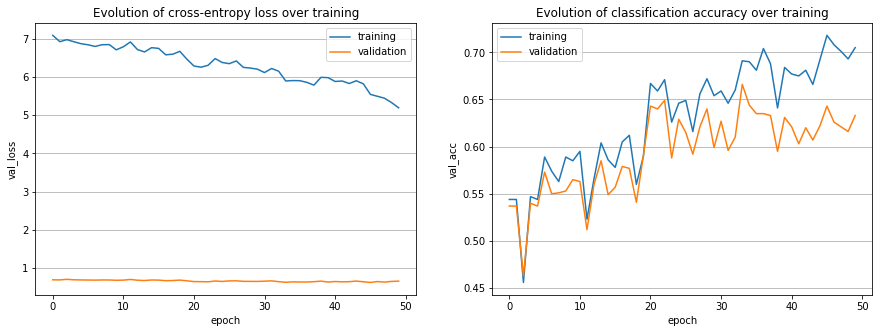

In [43]:
class ConvNetMatteo(nn.Module):
    def __init__(self, nb_hidden=100):
        super(ConvNetMatteo, self).__init__()
        self.conv1 = nn.Conv2d(2, 64, kernel_size=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=1)
        self.pool1 = nn.MaxPool2d(kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=1)
        self.pool3 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.fc1 = nn.Linear(256, 120)
        self.fc2 = nn.Linear(120, 60)
        self.fc3 = nn.Linear(60, 2)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = F.relu(x)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.conv7(x)
        x = self.pool3(x)
        x = F.relu(x)
        x = self.fc1(x.view(-1, 256))
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        return x
    
cnn = ConvNetMatteo()
histCNN = train_model(cnn, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
plot_hist(histCNN)

## Fully connected architecture (baseline)

Epoch 50/50


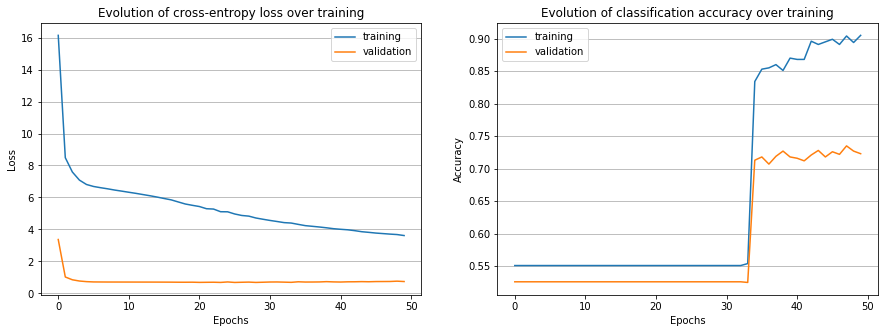

In [16]:
class FullyConnectedWith2HiddenLayers(nn.Module):
    
    def __init__(self, input_size):
        
        super(FullyConnectedWith2HiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 2)  
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out
    
model1 = FullyConnectedWith2HiddenLayers(392)
hist1 = train_model(model1, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist1)

## Fully connected architecture (more neurons)

Epoch 50/50


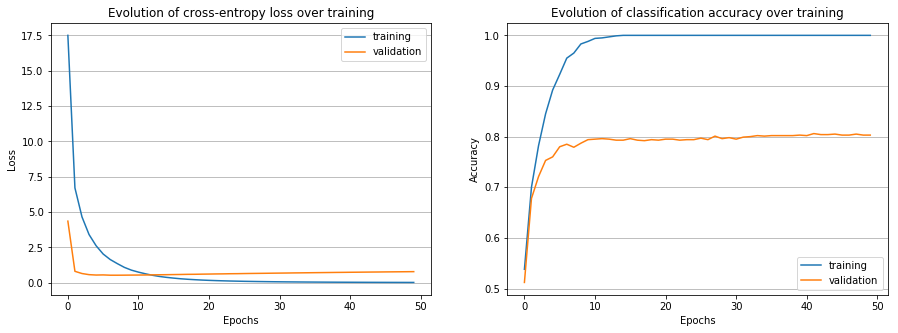

In [17]:
class FullyConnectedWith2HiddenLayers(nn.Module):
    
    def __init__(self, input_size):
        
        super(FullyConnectedWith2HiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, 100)
        self.fc2 = nn.Linear(100, 50)
        self.fc3 = nn.Linear(50, 2)  
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out
    
model2 = FullyConnectedWith2HiddenLayers(392)
hist2 = train_model(model2, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist2)

Epoch 50/50


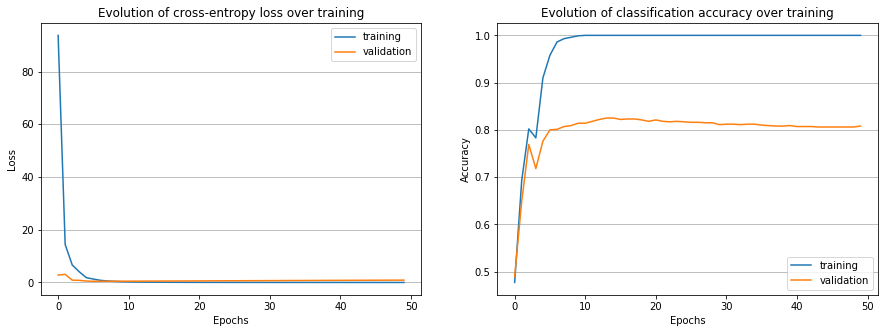

In [18]:
class FullyConnectedWith2HiddenLayers(nn.Module):
    
    def __init__(self, input_size):
        
        super(FullyConnectedWith2HiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 2)  
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out
    
model3 = FullyConnectedWith2HiddenLayers(392)
hist3 = train_model(model3, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist3)

## Fully connected architecture (different layers)

Epoch 50/50


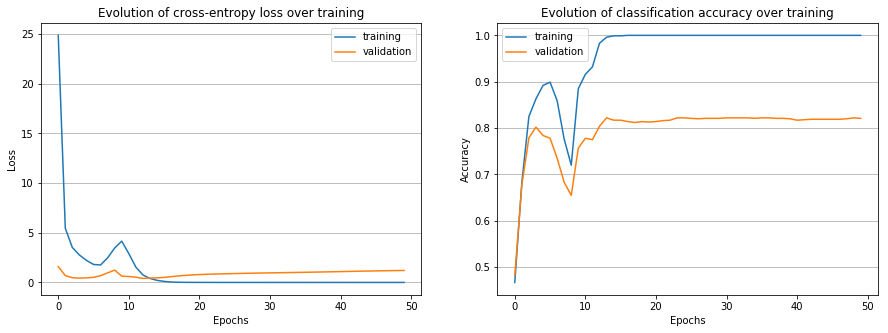

In [19]:
class FullyConnectedWith2HiddenLayers(nn.Module):
    
    def __init__(self, input_size):
        
        super(FullyConnectedWith2HiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, 1000)
        self.fc2 = nn.Linear(1000, 500)
        self.fc3 = nn.Linear(500, 100) 
        self.fc4 = nn.Linear(100, 2)
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        return out
    
model4 = FullyConnectedWith2HiddenLayers(392)
hist4 = train_model(model4, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist4)

In [ ]:
class FullyConnectedWith2HiddenLayers(nn.Module):
    
    def __init__(self, input_size):
        
        super(FullyConnectedWith2HiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, 5000)
        self.fc2 = nn.Linear(5000, 1000)
        self.fc3 = nn.Linear(1000, 500) 
        self.fc4 = nn.Linear(500, 100)
        self.fc5 = nn.Linear(100, 50)
        self.fc6 = nn.Linear(50, 2)
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        out = F.relu(out)
        out = self.fc4(out)
        out = F.relu(out)
        out = self.fc5(out)
        out = F.relu(out)
        out = self.fc6(out)
        return out
    
model5 = FullyConnectedWith2HiddenLayers(392)
hist5 = train_model(model5, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist5)

Epoch 13/50


In [ ]:
class FullyConnectedWith2HiddenLayers(nn.Module):
    
    def __init__(self, input_size):
        
        super(FullyConnectedWith2HiddenLayers, self).__init__()
        self.fc1 = nn.Linear(input_size, 10)
        self.fc2 = nn.Linear(10, 5)
        self.fc3 = nn.Linear(5, 2)  
    
    def forward(self, x):
        out = x.view(-1, 392)
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)
        out = F.relu(out)
        out = self.fc3(out)
        return out
    
model1 = FullyConnectedWith2HiddenLayers(392)
hist1 = train_model(model1, train_input, train_target, test_input, test_target, eta=0.0005, epochs=50)
utils.plot_hist(hist1)